## Seq2Seq LSTM model for predicting future consumption

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim
import functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [42]:
#Read dataset
path = "household_power_consumption.txt"
df = functions.load_data(path)

#Preprocess dataset and convert to hourly
df_hourly = functions.preprocess_data(df).reset_index()
df_hourly.head()

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333


In [46]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)

df_hourly["value lag_168"] = df_hourly["Global_active_power"].shift(168)
df_hourly = df_hourly.dropna().reset_index(drop=True)

In [40]:
df_hourly

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,weekday,day_of_week,value lag_168
0,2006-12-31 00:00:00,0.676233,0.147633,3.080000,243.457000,0.0,0.583333,0.000000,0.000000,-0.781831,6.432491e-16,4.028000
1,2006-12-31 01:00:00,0.716167,0.082967,3.223333,241.908167,0.0,0.000000,0.000000,0.258819,-0.781831,6.432491e-16,3.275700
2,2006-12-31 02:00:00,0.721933,0.134433,3.333333,246.602167,0.0,0.583333,0.000000,0.500000,-0.781831,6.432491e-16,2.303033
3,2006-12-31 03:00:00,0.778567,0.103233,3.590000,245.779833,0.0,0.000000,0.000000,0.707107,-0.781831,6.432491e-16,1.606767
4,2006-12-31 04:00:00,1.277767,0.066200,5.496667,244.057000,0.0,0.033333,8.566667,0.866025,-0.781831,6.432491e-16,1.576100
...,...,...,...,...,...,...,...,...,...,...,...,...
34219,2010-11-25 19:00:00,2.330467,0.151567,9.800000,237.729667,0.0,0.666667,8.366667,-0.965926,0.433884,-5.808003e-01,2.573933
34220,2010-11-25 20:00:00,1.647833,0.098033,6.826667,241.659000,0.0,0.550000,0.000000,-0.866025,0.433884,-5.808003e-01,2.164667
34221,2010-11-25 21:00:00,1.342933,0.049433,5.540000,240.698833,0.0,0.000000,0.000000,-0.707107,0.433884,-5.808003e-01,1.934967
34222,2010-11-25 22:00:00,1.247567,0.078933,5.160000,241.979500,0.0,0.000000,5.300000,-0.500000,0.433884,-5.808003e-01,0.922433


In [67]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

#Features to scale
features = ["Global_active_power","Global_reactive_power",
            "Global_intensity","Voltage",
            "Sub_metering_1","Sub_metering_2","Sub_metering_3","value lag_168"]

class ConsumptionDataset(Dataset):
    def __init__(self,X,y,seq_len=72,horizon=24):
        self.X = X
        self.y = y
        self.seqlen = seq_len
        self.horizon = horizon
        
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx:idx+self.seqlen],dtype=torch.float32)
        y = torch.tensor(self.y[(idx+self.seqlen):(idx+self.seqlen+self.horizon)],dtype=torch.float32)
        return X,y
    def __len__(self):
        return len(self.y)-self.seqlen-self.horizon

train_df = df_hourly.iloc[:-365*24,1:]
train_df, val_df = train_test_split(train_df,test_size=0.3,shuffle=False)
test_df = df_hourly.iloc[-365*24:,1:]


X_scaler.fit(train_df[features])
Y_scaler.fit(train_df[["Global_active_power"]])

train_targets = Y_scaler.transform(train_df[["Global_active_power"]])
train_df[features] = X_scaler.transform(train_df[features])

valid_targets = Y_scaler.transform(val_df[["Global_active_power"]])
val_df[features] = X_scaler.transform(val_df[features])

test_targets = Y_scaler.transform(test_df[["Global_active_power"]])
test_df[features] = X_scaler.transform(test_df[features])

traindata = ConsumptionDataset(train_df.to_numpy(),train_targets)
validdata = ConsumptionDataset(val_df.to_numpy(),valid_targets)
testdata = ConsumptionDataset(test_df.to_numpy(),test_targets)
trainloader = DataLoader(traindata,batch_size=128,shuffle=False)
validloader = DataLoader(validdata,batch_size=128,shuffle=False)
n_features  = df_hourly.iloc[:,1:].shape[1]

In [ ]:

class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers,output_size):
        super().__init__()
        self.encoder = nn.LSTM(n_features,hidden_size,num_layers,batch_first=True)
        self.decoder = nn.LSTM(1,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
        self.output_size = output_size
        self.dropout = nn.Dropout(0.2)
        self.input_dropout = nn.Dropout(0.15)
    def forward(self,X):
        # Encoding
        _, (h,c) = self.encoder(X)
        
        #Input for decoder
        decoder_input = torch.zeros(X.size(0),1,1,device=X.device)
        outputs = []

        for i in range(self.output_size):
            out, (h,c) = self.decoder(decoder_input, (h,c))
            out = self.dropout(out)
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)

In [69]:
from importlib import reload
reload(functions)
n_features  = df_hourly.iloc[:,1:].shape[1]
hidden_size = 64
num_layers = 1
output_size = 24

batch_size = 128
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 5*10**(-4))


epochs = 50
losses = []
model = model.to(device)
loss_fn = loss_fn.to(device)
model_path = "adaml_lstm_jr.pth"
epoch_vector = np.linspace(1,epochs,epochs)
trainlossvector = np.linspace(1,epochs,epochs)
validlossvector = np.zeros(epoch_vector.shape)
min_validloss = np.inf
for epoch in range(epochs):
    trainlossvector[epoch] = functions.trainloop(trainloader,model,loss_fn,optimizer,batch_size,device)
    min_validloss,validlossvector[epoch] = functions.validationloop(validloader,model,loss_fn,min_validloss,device)
    #Save best model
    if min_validloss>=validlossvector[epoch]:
        torch.save(model.state_dict(),model_path)
    if (epoch+1)%1 == 0:
        print(f"Epoch: {epoch+1} | Average training loss {trainlossvector[epoch]}, Validation loss {validlossvector[epoch]}")
#torch.save(model.state_dict(),model_path)

Epoch: 1 | Average training loss 0.00024276010946392543, Validation loss 0.00015383939058925938
Epoch: 2 | Average training loss 0.00017150068033876533, Validation loss 0.00012793517358081566
Epoch: 3 | Average training loss 0.00017297178428482316, Validation loss 0.00012199917837454878
Epoch: 4 | Average training loss 0.00017099909376096836, Validation loss 0.00011855185001359805
Epoch: 5 | Average training loss 0.00016176524453722496, Validation loss 0.00012654228626192218
Epoch: 6 | Average training loss 0.00015641577366775928, Validation loss 0.0001204035380457548
Epoch: 7 | Average training loss 0.00014926108348455974, Validation loss 0.00010417197476489385
Epoch: 8 | Average training loss 0.00014320291297770395, Validation loss 9.929314529743227e-05
Epoch: 9 | Average training loss 0.00013900860460041821, Validation loss 9.76822869850934e-05
Epoch: 10 | Average training loss 0.0001351195168460764, Validation loss 9.358544224212764e-05
Epoch: 11 | Average training loss 0.000129616

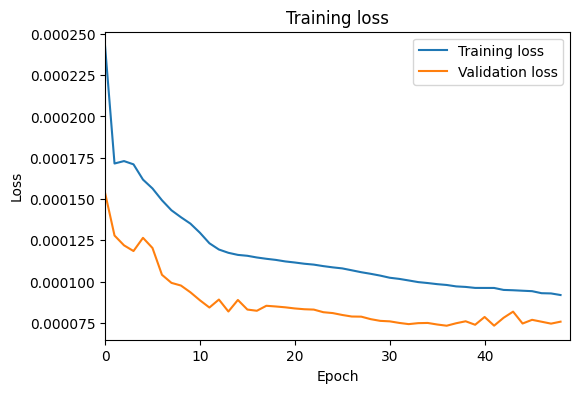

In [81]:

plt.figure(figsize=(6,4))
plt.plot(trainlossvector[:epoch],label="Training loss")
plt.plot(validlossvector[:epoch],label="Validation loss")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0,49)
plt.legend()
plt.show()

In [82]:
model_path = "adaml_lstm_jr.pth"
n_features  = df_hourly.iloc[:,1:].shape[1]
hidden_size = 64
output_size = 24

prev_consumption = []
y_preds = []
y_actuals = []
model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
model = model.to("cpu")




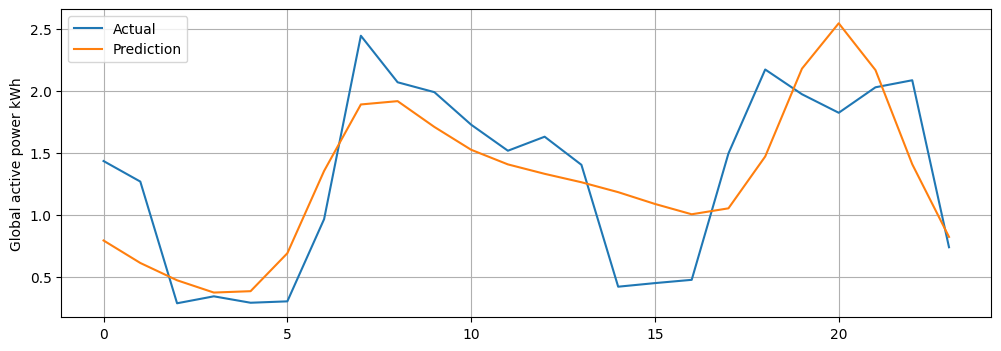

In [ ]:
#Calculate samples
i = 1200

X_torch, y_actual = testdata.__getitem__(i)
y_actuals = y_actual.numpy()
with torch.no_grad():
    y_pred = model(X_torch.unsqueeze(0))
y_preds = y_pred.numpy()[0]
plt.figure(figsize=(12,4))
plt.plot(Y_scaler.inverse_transform(np.array(y_actuals).reshape(-1,1)),'-',label="Actual")
plt.plot(Y_scaler.inverse_transform(np.array(y_preds).reshape(-1,1)),label="Prediction")
plt.legend()
plt.grid()
plt.ylabel("Global active power kWh")
plt.show()

C:\Users\toniv\AppData\Local\Temp\ipykernel_26540\847916184.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_horizon["Pred"] = pred


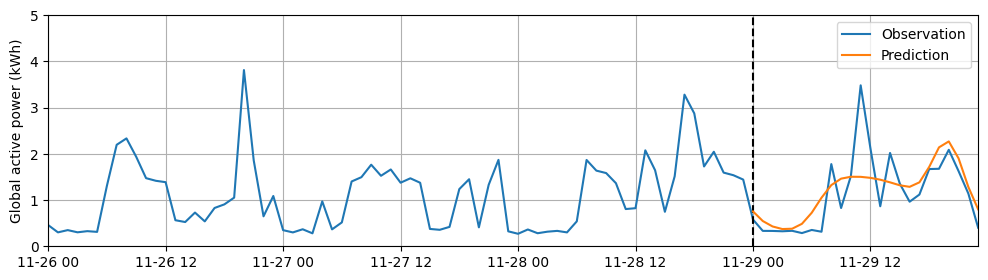

In [173]:
i = 0
df_sample = df_hourly.iloc[(-365*24+i):(-365*24+96+i)].reset_index(drop=True)
plt.figure(figsize=(12,3))
#Samples before forecast
start = 0
end = start + 72
T = 24
plt.plot(df_sample["datetime"],df_sample["Global_active_power"],label="Observation")
plt.vlines(df_sample["datetime"].iloc[end],0,5,linestyles="dashed",colors="black")

X = df_sample.iloc[start:end,1:]
X[features] = X_scaler.transform(X[features])
X_tensor = torch.tensor(X.to_numpy(),dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    pred_scaled = model(X_tensor)
    pred_scaled = pred_scaled.squeeze(0).cpu().numpy()
pred = Y_scaler.inverse_transform(pred_scaled)
df_pred_horizon = df_sample.iloc[-T:]
df_pred_horizon["Pred"] = pred
plt.plot(df_pred_horizon["datetime"],df_pred_horizon["Pred"],label="Prediction")
plt.xlim(df_sample["datetime"].iloc[start],df_sample["datetime"].iloc[end+T-1])
plt.ylim(0,5)
plt.ylabel("Global active power (kWh)")
plt.legend()
plt.grid()
plt.show()